<a href="https://colab.research.google.com/github/dler-jawhar/Emen/blob/master/DL_Assignment_1_Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Please add your names in this cell.**<br>
Vihara Jayaweera,10076015<br>
Dler Ahmed, 10076011<br>
<name_person_2>, <matriculation_number_person_2><br>
<name_person_3>, <matriculation_number_person_3><br>

# Home assignment 1

### Deadline: 19th November, 2024 at 23:59 CET

In this assignment we go through the following topics:
- Making a Data set class that inherits from `torch.utils.data.Dataset`
- Data Augmentation
- Transfer Learning or Fine Tuning
- Making a function for training

We are going to implement an image segmentation model for a pet dataset. We will use a pre-trained [Mask R-CNN](https://arxiv.org/abs/1703.06870) model.

### Image Segmentation

In an image segmentation task, a class is assigned to each pixel of the image.

Image segmentation is typically used to locate objects and boundaries in images and has many applications in medical imaging, self-driving cars and satellite imaging, for example.


This tutorial uses the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) (Parkhi et al, 2012). The dataset consists of images of 37 pet breeds, with 200 images per breed (~100 each in the training and test splits). Each image includes the corresponding labels, and pixel-wise masks. The masks are class-labels for each pixel. Each pixel is given one of three categories:

   * Class 1: Pixel belonging to the pet.
   * Class 2: Pixel bordering the pet.
   * Class 3: None of the above/a surrounding pixel.

### Setup


In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import (
    MaskRCNN_ResNet50_FPN_Weights,
    MaskRCNNPredictor,
)
from torchvision.transforms import functional

# Define a directory where you want to store the dataset
# We recommend using Colab, if you do not have a GPU!
colab_dir = "./data/"  # Update this with your directory

# Load the dataset using the updated paths
pets_path_train = os.path.join(colab_dir, "OxfordPets", "train")
pets_path_test = os.path.join(colab_dir, "OxfordPets", "test")


### Define Datasets
The dataset consists of `(image, mask)` tuples. The image is a standard RGB PIL image. The masks are a single-channel PIL image where each pixel is one of the three category label values (0, 1 or 2).
PIL images can be transformed to Tensors using [torchvision.transforms.functional.pil_to_tensor](https://pytorch.org/vision/0.11/transforms.html#torchvision.transforms.functional.pil_to_tensor) or vice-versa with [torchvision.transforms.functional.to_pil_image](https://pytorch.org/vision/0.11/transforms.html#torchvision.transforms.functional.to_pil_image).

In [ ]:
# Define the dataset and test dataset
dataset = torchvision.datasets.OxfordIIITPet(
    root=pets_path_train,
    split="trainval",
    target_types="segmentation",
    download=True,
)
dataset_test = torchvision.datasets.OxfordIIITPet(
    root=pets_path_test,
    split="test",
    target_types="segmentation",
    download=True,
)

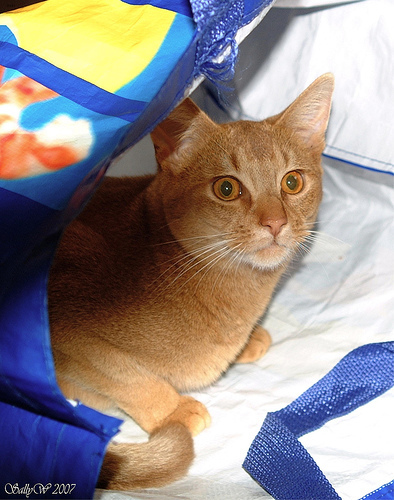

In [ ]:
image, mask = dataset[0]
# Show one image
image


In [ ]:
# Print the mask Tensor
functional.pil_to_tensor(mask)

tensor([[[2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         ...,
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2]]], dtype=torch.uint8)

### Define transforms

These transforms augment the training data to improve the robustness of the model.
Use at least 3 different transforms for augmenting the data.
The transforms should augment the image, e.g., distort, crop or rotate.
Transforms that only convert the image to Tensors do not count as augmentation.

See https://pytorch.org/vision/0.11/transforms.html for a list of all transforms.


In [ ]:
data_transforms = transforms.Compose(
    [
        # TODO: Add data augmentation transforms here
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(90) #range of degrees [-90,90]

    ]
)


### Define Collate Functions and Dataloaders
Notes:
- You do not have to use collate functions. However they are an easy way to apply methods to and order the data. The data is given as a list of `(image, mask)` tuples, but depending on your implementation, it may be beneficial to load the batches as a tuple of lists, i.e., `([images], [masks])`. The required reordering can be achieved using a collate function.
- Apply the above transforms to the training data. Keep in mind, you should apply the same transforms to the image and mask.
- The model requires a binary mask. Set all pixels that are not the pet in the image to 0.
- You should use a separate collate function for the train and test set. The test set does not need to be transformed, but converted to tensors.

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import (
    MaskRCNN_ResNet50_FPN_Weights,
    MaskRCNNPredictor,
)
from torchvision.transforms import functional

# Collate function for the train set
def collate_train(batch):
  outImages = []
  outMasks = []

  for image, mask in batch:
    # Get seed
    seed = torch.seed()

    # Set seed
    torch.manual_seed(seed)
    # Apply transformation to image
    image = data_transforms(image)

    # Set same seed
    torch.manual_seed(seed)
    # Apply SAME transformation to mask
    mask = data_transforms(mask)

    # Process mask to be binary
    mask = np.array(mask)
    petPixels = np.where(mask[:,:] == 1)
    borderPixels = np.where(mask[:,:] == 3)
    mask[:,:] = 0
    mask[petPixels] = 1
    mask[borderPixels] = 1

    # Save result
    outImages.append(image)
    outMasks.append(mask)

  # output tuple
  return (outImages, outMasks)

# Collate function for the test set
def collate_test(batch):
  outImages = []
  outMasks = []

  for image, mask in batch:
    # Convert to tensors
    image = functional.pil_to_tensor(image)
    mask = functional.pil_to_tensor(mask)

    # Save result
    outImages.append(image)
    outMasks.append(mask)

  # output tuple
  return (outImages, outMasks)


# Create data loaders for training and testing (using DIFFERENT collate functions!)
# Feel free to use custom hyperparameters
batch_size = 4  # Reduced batch size from 8 to 4
data_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_train,
)
data_loader_test = DataLoader(
    dataset_test, batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_test # Reduced batch size from 8 to 4
)

### Example images
To check that the masks and transforms are calculated correctly, plot four images, their masks, the transformed version and the corresponding mask.

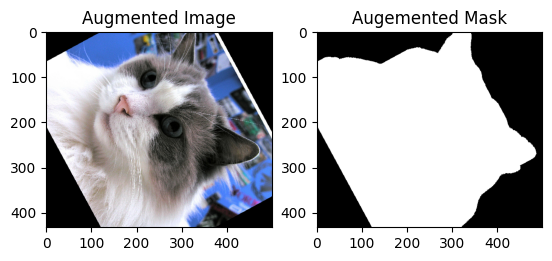

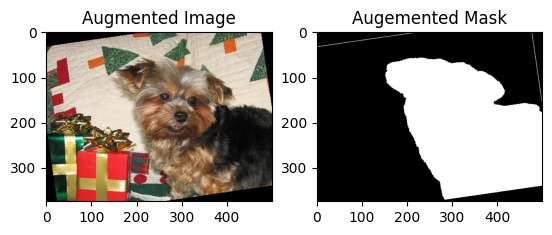

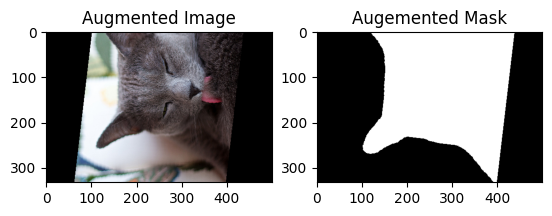

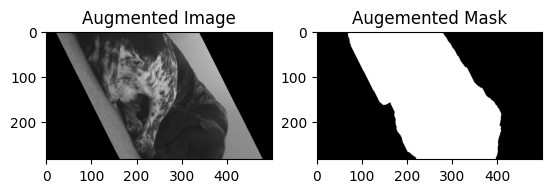

In [ ]:
# Visualize original and augmented versions of four images
for images, masks in data_loader:
    # Visualize the augmented images and masks
    for j in range(batch_size):
        # TODO: Create subplots and display the images and masks
        # Hint: Use Matplotlib to show images and masks in subplots
        # You should display both original and augmented images and masks
        # Customize the titles and formatting as needed
        plt.subplot(1,2,1)
        plt.imshow(images[j])
        plt.title("Augmented Image")

        plt.subplot(1,2,2)
        plt.imshow(masks[j], cmap=plt.cm.gray)
        plt.title("Augemented Mask")
        plt.show()

    break



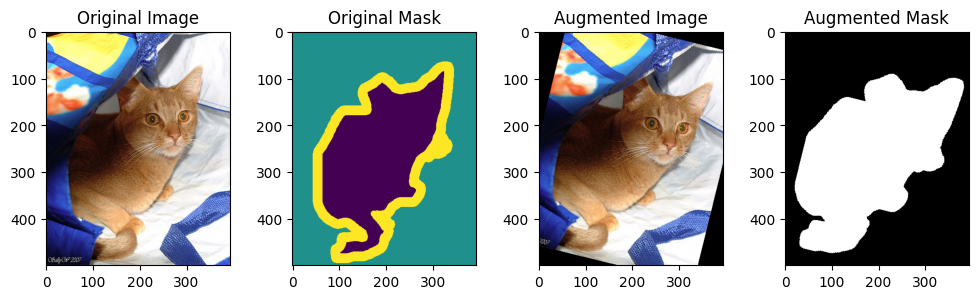

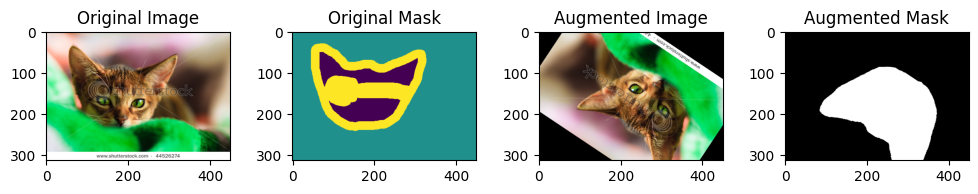

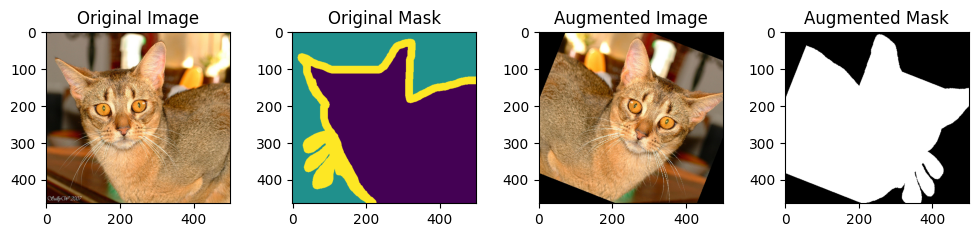

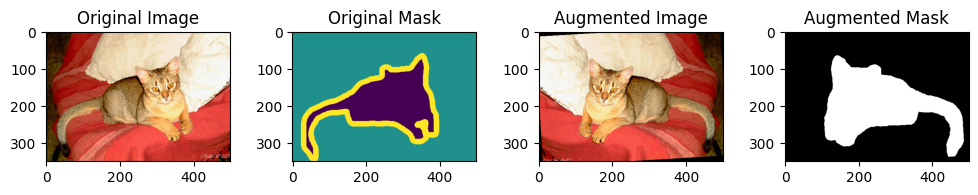

In [ ]:
# Cell added by Vihara for part 1b)
data_loader = DataLoader(
    dataset, batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_train
)

# Visualize original and augmented versions of four images
for images, masks in data_loader:

    for j in range(4):
        fig, ax = plt.subplots(1,4, figsize=(10, 10))
        fig.tight_layout()

        oImage, oMask = dataset[j]

        ax[0].set_title("Original Image")
        ax[0].imshow(oImage)

        ax[1].set_title("Original Mask")
        ax[1].imshow(oMask)

        ax[2].set_title("Augmented Image")
        ax[2].imshow(images[j])

        ax[3].set_title("Augmented Mask")
        ax[3].imshow(masks[j],cmap=plt.cm.gray)

    break



### Introduction to transfer learning


* Transfer learning is an ML methods to **reuse a pre-trained model** on a new problem by exploiting the knowledge gained from a previous task to improve generalization about another similar task.
* Steps:
  1. Select a pre-trained source model
  2. Adapt the source model to create the target model
  3. Fine-tuning: Train source model to achieve the target model
* Strategies for fine-tuning of model:
* There are different **strategies for fine-tuning** the model: You can train the entire model or only some layers and leave the others frozen. Usually, if you have a small dataset and a large number of parameters, you will leave more layers frozen to avoid overfitting. By contrast, if the dataset is large and the number of parameters is small, you can improve your model by training more layers to the new task since overfitting is not an issue.
* **Main benefits:** less training data needed, better initial model, higher learning rate, faster training, higher accuracy after training
* **Example:** In training a classifier to predict the animal species, you could use the knowledge it gained during training to recognize dog breeds.


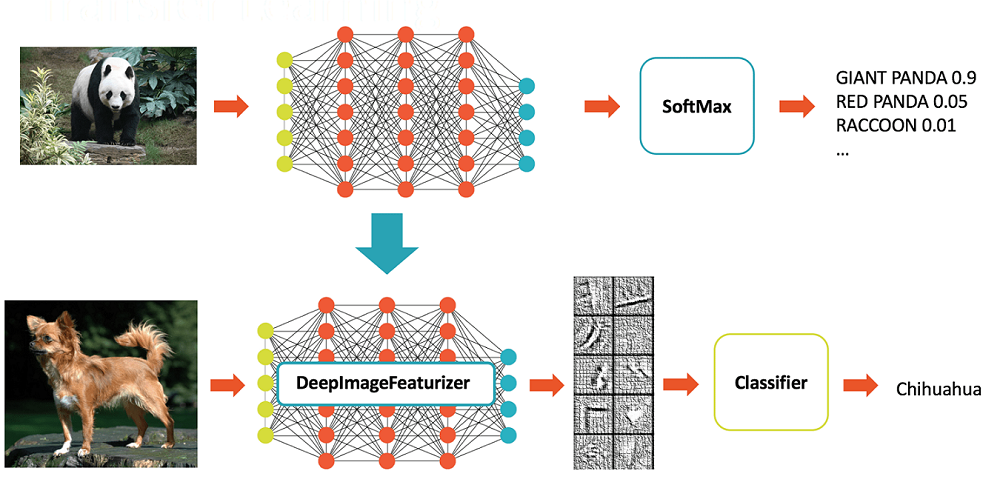

### Defining model and Prediction

In this tutorial, we will be using [Mask R-CNN](https://arxiv.org/abs/1703.06870), which is based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

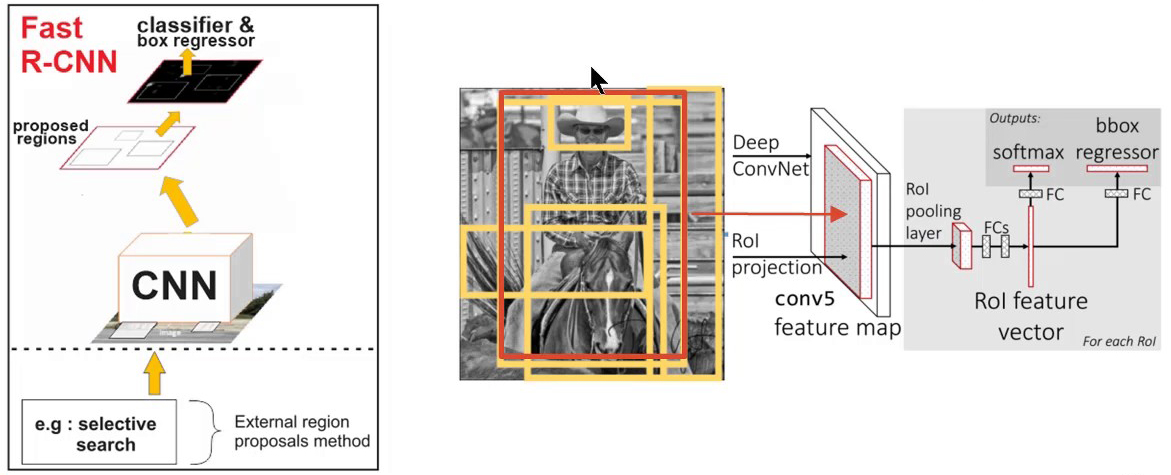


Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

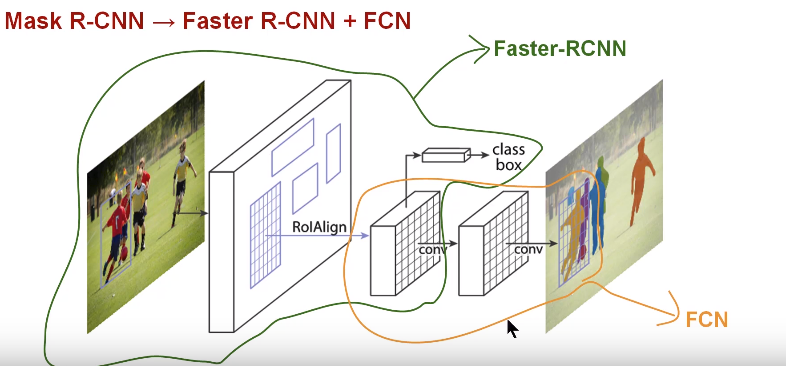





One of popular ways to modify models in torchvision modelzoo when we want to use a pre-trained model, and just finetune the last layer is transfer learning. In our task we want to also compute the segmentation masks, so we will be using Mask R-CNN.

### Define some hyperparameters:
Feel free to test some other options

In [ ]:
NUM_CLASSES = 2
HIDDEN_LAYER = 256
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

This part initializes the model, optimizer and learning rate scheduler.

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Model Setup:
# Load a pre-trained Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(
    weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT
)

# Get the number of input features for the classifier and replace the head for the box predictor
in_features = model.roi_heads.box_predictor.cls_score.in_features
# Replace the head for the box predictor with FastRCNNPredictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

# Get the number of input features for the mask classifier and replace the mask predictor
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
# Replace the mask predictor with MaskRCNNPredictor
model.roi_heads.mask_predictor = MaskRCNNPredictor(
    in_features_mask, HIDDEN_LAYER, NUM_CLASSES
)

# Move the model to the appropriate device
model.to(device)


# Optimizer and Learning Rate Scheduler:
# Create an optimizer with proper lr, momentum, and weight decay
optimizer = torch.optim.SGD(
    model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0001
)

# Create a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


Some notes that may or may not be applicable to you:
- You may have to check if a bounding box is valid (i.e., contains foreground/pets and is not 0-width or 0-height)
- Filter out all masks that have invalid bounding boxes

Now, let’s make a function for training each epoch:

In [ ]:
transform_to_tensor = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

def filter_masks(images, masks):
    # You may not need to implement this, depending on your other implementation
    # If the model does not learn correctly, please check if removing invalid bounding boxes from the batch fixes the issue (see notes above this cell)

    # We're getting PIL images and masks. get_boxes() processes a tensor...?
    filtered_images = []
    filtered_masks = []

    for img, mask in zip(images, masks):
        m = transform_to_tensor(mask).to(device)
        boxes = get_boxes(m)

        save = True
        for box in boxes:
          w = (box[2] - box[0]).item()
          h = (box[3] - box[1]).item()
          if w == 0 or h == 0: # 0 width or height
            save = False
            print("removed here {} h {} w {}".format(box,h,w))
            break

          areaOfInterest = m[:,box[0]:box[2], box[1]:box[3]]

          if areaOfInterest.squeeze().nonzero() == []: # No pet pixels
            save = False
            arr = np.array(areaOfInterest)
            print("removed {}".format(np.unique(arr)))
            break


        if save:
          filtered_images.append(img)
          filtered_masks.append(mask)

    return filtered_images, filtered_masks


def get_boxes(mask):
    pos = mask.squeeze().nonzero()
    boxes = torch.as_tensor(
        [
            torch.min(pos[:, 1]),
            torch.min(pos[:, 0]),
            torch.max(pos[:, 1]),
            torch.max(pos[:, 0]),
        ],
        dtype=torch.int64,
    ).unsqueeze(0)
    return boxes


def train(model, optimizer, dataloader, device, epoch, print_freq=1):
    model.train()

    for images, masks in dataloader:
        images, masks = filter_masks(images, masks)
        # Convert the PIL Images to PyTorch tensors
        images = [transform_to_tensor(image).to(device) for image in images]
        masks = [transform_to_tensor(mask).to(device) for mask in masks]

        targets = [
            {
                "boxes": get_boxes(masks[i]).to(device),
                "labels": torch.ones(1, dtype=torch.int64).to(device),
                "masks": masks[i],
                "image_id": i,
            }
            for i in range(len(images))
        ]

        # TODO: Add your code here to complete the training loop, containing predicting, loss computation and optimizer steps
        losses = model(images, targets)

        # Sum the losses from the model
        loss = sum(loss for loss in losses.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % print_freq == 0:
        print("Epoch: [{}/{}]".format(epoch, num_epochs))
        # TODO: Add code to print the loss
        print("Loss {}".format(loss.item()))


And now let's train the model for 10 epochs, evaluating at the end of every epoch.

NOTE: If you run into memory issues here, you can reduce the number of epochs, the batch size, or only use a subset of the dataset. If you decide to opt for one or more of these, please clearly make a note!

In [ ]:
# Update the number of epochs
num_epochs = 5

# TODO: Update the dataloader *if needed*

# My dataloader
# Reduced
#       - number of epochs = 5
#       - batch size = 1
#       - only a subset of the data was used (first 10 images, masks)
subset = torch.utils.data.Subset(dataset, range(10))
data_loader = DataLoader(
    subset, batch_size=1, shuffle=False, num_workers=1, collate_fn=collate_train
)
# Call the train function
for epoch in range(num_epochs):
    print(epoch)
    train(model, optimizer, data_loader, device, epoch, print_freq=1)
    lr_scheduler.step()


0
Epoch: [0/5]
Loss 0.1592809557914734
1
Epoch: [1/5]
Loss 0.2174597829580307
2
Epoch: [2/5]
Loss 0.20962956547737122
3
Epoch: [3/5]
Loss 0.24777017533779144
4
Epoch: [4/5]
Loss 0.1466262936592102


In [ ]:
torch.cuda.empty_cache()

Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.
### Training and evaluation:


### Prediction:
Now that training has finished, let's have a look at what it actually predicts in a test image

In [ ]:
# Pick one image from the test set
img, _ = dataset_test[0]

# Put the model in evaluation mode
model.eval()

# TODO: Continue the code to make predictions with the model
tensor = functional.to_tensor(img).to(device)

prediction = None
with torch.no_grad():
  prediction = model([tensor])


Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed.

In [ ]:
prediction

[{'boxes': tensor([[ 27.0811,  56.1919, 206.0752, 217.2777],
          [ 89.7340,  17.0712, 293.1635, 218.1636],
          [173.8144,  19.5851, 274.0960, 200.1590],
          [113.3167,   5.2223, 296.5101, 125.5355],
          [181.8479,  14.9407, 252.8957, 111.4477],
          [ 89.9773,  74.1148, 190.3007, 216.6632],
          [  0.0000,  20.9238, 134.3334, 214.5861],
          [129.8077,  85.6870, 292.4368, 203.8636],
          [ 33.3110,  14.8487, 272.4265, 150.7035],
          [ 43.8758, 112.2275, 293.6262, 221.4331],
          [ 74.9132,  56.3447, 180.0841, 139.3743],
          [ 61.5911,  80.6206, 171.7210, 156.5552]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.8945, 0.5529, 0.5245, 0.4654, 0.3369, 0.1683, 0.1683, 0.1619, 0.1575,
          0.1475, 0.0865, 0.0554], device='cuda:0'),
  'masks': tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
             0.0000e+00, 0.0000e+00],
            [0

Let's inspect and visualize the image and the top predicted segmentation masks.


Text(0.5, 1.0, 'Real Mask')

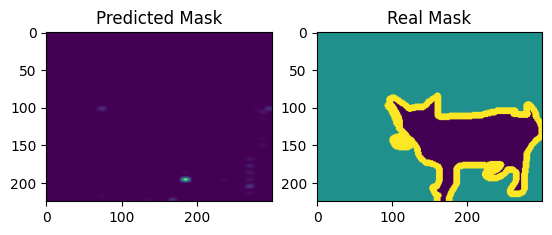

In [ ]:
# TODO
pred_mask = prediction[0]["masks"][0].cpu().numpy()
pred_mask = np.moveaxis(pred_mask, 0, -1)

fig, ax = plt.subplots(1,2)
ax[0].imshow(pred_mask)
ax[0].set_title("Predicted Mask")
ax[1].imshow(_)
ax[1].set_title("Real Mask")

And let's now visualize the top predicted segmentation mask.

In [ ]:
# TODO
# Refer to above plot

For some other examples visualize original image and all predicted segmentation masks.

In [ ]:
# TODO

### Evaluation
In semantic segmentation tasks, you want to assess the quality of pixel-wise predictions made by your model. This includes metrics like Intersection over Union (IoU), Dice Coefficient, and Pixel Accuracy.

We recommend using [torchmetrics](https://torchmetrics.readthedocs.io/en/v0.9.3/).

In [ ]:
# TODO: Evaluate your model and compute relevant semantic segmentation metrics
# 1. Calculate and print the Intersection over Union (IoU) for each class and the mean IoU.
# 2. Calculate and print the Dice Coefficient for each class and the mean Dice Coefficient.
# 3. Compute and print the Pixel Accuracy.

import torch
from torchmetrics import BinaryJaccardIndex
from ignite.metrics import DiceCoefficient
from ignite.metrics.confusion_matrix import ConfusionMatrix


def getIOU(pred, target):
  # Source - https://stackoverflow.com/a/68268718
    # Posted by Dominik Filipiak, modified by community. See post 'Timeline' for change history
    # Retrieved 2025-11-18, License - CC BY-SA 4.
    jaccard = BinaryJaccardIndex()
    result = jaccard(pred, target)
    return result

def getDiceCoeff(pred, target):
  conf_mat = ConfusionMatrix(2)



